In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/MyDrive/Colab Notebooks/뉴스 토픽 분류 경진대회/open2.zip" "open2.zip"
# data.zip을 현재 디렉터리에 압축해제
!unzip "open2.zip"

!cp "/content/drive/MyDrive/Colab Notebooks/뉴스 토픽 분류 경진대회/ko.zip" "ko.zip"
!unzip "ko.zip"
output.clear()

In [2]:
# import library 
import numpy as np
from numpy.lib.function_base import _cov_dispatcher
import scipy as sp
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

# 한국어 형태소 및 문장 분석 라이브러리

!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install nltk
!pip install konlpy

'''
!git clone https://github.com/kakao/khaiii.git 
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python
from khaiii import KhaiiiApi
'''

from konlpy.tag import Kkma
from pykospacing import Spacing
import nltk
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
output.clear()

In [5]:
# text data & label data load

PATH = "./"
df_train = pd.read_csv(PATH + "train_data.csv")
df_test = pd.read_csv(PATH + "test_data.csv")
topic_dict = pd.read_csv(PATH + "topic_dict.csv")
kr_stopwords_list = pd.read_csv(PATH + "korean_stopwords.csv", header = None, names = ['word'])["word"].tolist()

print("훈련 데이터 크기: ", df_train.shape)
print("예측 데이터 크기: ", df_test.shape)

훈련 데이터 크기:  (45654, 3)
예측 데이터 크기:  (9131, 2)


In [6]:
print("#훈련 데이터")
display(df_train.head())
print("\n#예측 데이터")
display(df_test.head())

#훈련 데이터


,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4



#예측 데이터


,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [7]:
# 뉴스 토픽 주제 분류
print(topic_dict["topic"].values)

['IT과학' '경제' '사회' '생활문화' '세계' '스포츠' '정치']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


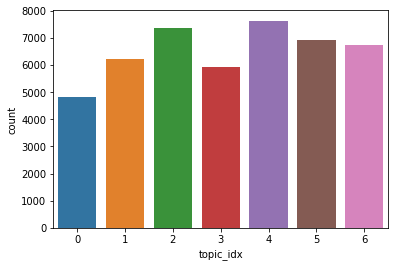

In [8]:
import seaborn as sns

topic_dictionary = topic_dict.to_dict

def idx_to_topic(idx):
    if idx <= len(topic_dict["topic"]):
        return topic_dict["topic"][idx]
    else:
        ValueError("enter the index below the length of topic_idx")

datasets_eda = df_train.copy()
datasets_eda["topic"] = datasets_eda.loc[:, "topic_idx"].apply(idx_to_topic).values.reshape(-1,1)

#sns.countplot( x = "topic", data = datasets_eda) # 한글은 출력 안됨....
sns.countplot(df_train["topic_idx"])

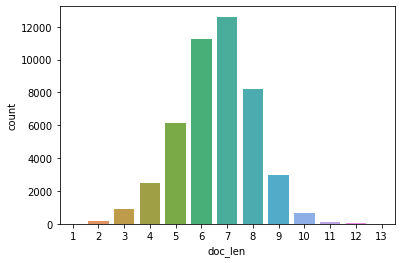

In [9]:
# 문장별 구성 단어 수 vs 텍스트 문서의 수
datasets_eda["doc_len"] = datasets_eda.title.apply(lambda words : len(words.split()))
sns.countplot(x = "doc_len", data = datasets_eda)

In [10]:
datasets_eda[datasets_eda["doc_len"] == 2]["title"]

1101             건배하는 김정은시진핑
1220                C페스티벌 개막
1485                 신간 지옥사원
1750                 신간 틈새경제
2061               인사말하는 진선미
                ...         
44040             미디어교육원 개관식
44776       한국소설문학상에 정수남·박영래
44796               융합교육의 현장
44912    기자회견하는 인천국제공항보안검색노조
45592                  신간 참선
Name: title, Length: 185, dtype: object

In [11]:
datasets_eda[datasets_eda["doc_len"] == 1]["title"]

20911           함께아리랑
27489      WatchPlay란
43922            국무회의
45153    노사관계발전자문위원회의
Name: title, dtype: object

In [12]:
obs_len = 5

print("# topic : IT과학 #")
display(datasets_eda[datasets_eda["topic_idx"] == 0][0:obs_len])

print("\n# topic : 경제 #")
display(datasets_eda[datasets_eda["topic_idx"] == 1][0:obs_len])

print("\n# topic : 사회 #")
display(datasets_eda[datasets_eda["topic_idx"] == 2][0:obs_len])

print("\n# topic : 생활문화 #")
display(datasets_eda[datasets_eda["topic_idx"] == 3][0:obs_len])

print("\n# topic : 세계 #")
display(datasets_eda[datasets_eda["topic_idx"] == 4][0:obs_len])

print("\n# topic : 스포츠 #")
display(datasets_eda[datasets_eda["topic_idx"] == 5][0:obs_len])

print("\n# topic : 정치 #")
display(datasets_eda[datasets_eda["topic_idx"] == 6][0:obs_len])

# topic : IT과학 #


,index,title,topic_idx,topic,doc_len
617,617,지카바이러스도 규명한 초저온전자현미경…신약연구에 유용,0,IT과학,4
622,622,증강현실 ① 알파고 이어 포켓몬 고…거센 IT 광풍,0,IT과학,8
643,643,AI 월드컵 생생한 현장 중계도,0,IT과학,5
654,654,이세돌 알파고 집중력 사람이 이기긴 어렵다 일문일답종합2보,0,IT과학,7
660,660,올해 휴대폰 국내 생산량 2천500만대…10년전의 18.4%,0,IT과학,6



# topic : 경제 #


,index,title,topic_idx,topic,doc_len
761,761,못믿을 아파트 관리비…경기 556곳서 150억 비리 적발종합,1,경제,7
765,765,특징주 관리종목 해제 대우조선해양 강세,1,경제,5
767,767,특징주 강원랜드 실적 부진에 급락종합,1,경제,5
769,769,라면 수출 질주…올해 4억달러 첫 돌파 확실시,1,경제,7
774,774,경기지표 부진 골드만삭스 한은 금리인상 예상시기 7→10월로종합,1,경제,7



# topic : 사회 #


,index,title,topic_idx,topic,doc_len
2458,2458,드라마 제작환경 개선 촉구,2,사회,4
2460,2460,창원세계사격대회장서 경남 시·군 관광 세계에 알린다종합,2,사회,6
2465,2465,조배숙 중앙위 정례회의 주재,2,사회,4
2474,2474,인천공항→송도 택시요금 12만원…바가지 택시·콜밴,2,사회,4
2478,2478,조용중 전 연합뉴스 사장 별세,2,사회,5



# topic : 생활문화 #


,index,title,topic_idx,topic,doc_len
953,953,황석영 작가 미국 문학축제서 한국문학 알린다,3,생활문화,6
960,960,휴일 불청객 울산 미세먼지 주의보 발령,3,생활문화,6
963,963,김수영 신임 한국출판문화산업진흥원장,3,생활문화,3
965,965,신간 한반도평화 오디세이,3,생활문화,3
968,968,2019 가극 금강 낭독공연 간담회,3,생활문화,5



# topic : 세계 #


,index,title,topic_idx,topic,doc_len
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,7



# topic : 스포츠 #


,index,title,topic_idx,topic,doc_len
52,52,박찬호 현진이 10승 하니깐 생각이 나는데…,5,스포츠,6
54,54,고군분투 시즌 서재덕 MVP 덕큐리로 활짝 웃다종합,5,스포츠,7
58,58,임도헌 감독 신영석 중심으로 똘똘 뭉쳐 한일전 승리 따냈다,5,스포츠,9
63,63,데얀·김치우 OUT 조영욱 IN…서울 과감한 재건 성과...,5,스포츠,7
66,66,호날두 노쇼 유벤투스 무책임·거만 비판 수용 어려워,5,스포츠,7



# topic : 정치 #


,index,title,topic_idx,topic,doc_len
43,43,김영남 우리 민족 위상 과시…뜨거운 분위기 이어가길,6,정치,7
48,48,적극행정 추진전략 및 성과공유대회 참석한 이낙연 총리,6,정치,7
49,49,朴대통령 한일 합의에 소녀상 언급없어…선동하면 안돼,6,정치,6
50,50,민주 국회의원 재보선 4곳 후보 공모에 7명 신청,6,정치,8
53,53,현행 헌법과 다른 점은 ②지방자치·경제민주화 개념 강화,6,정치,7


In [ ]:
# preprocessing
# 한국어 불용어 처리
# re를 통한 정규화
# spacing 혹은 pos taging을 통해 명사만을 추출한다. 

# 전처리 진행
- 불용어 처리
- pos taging을 이용한 명사 추출(접두사, 어미 제거)
- re 라이브러리를 이용한 정규화(html 태그 및 각종 수식 문구 제거)
- stemming / lemmatization : 어간 추출 및 표제어 추출
- 논의사항:
    1) 외래어, 영문자는 제거해야 하는가?
    2) 한문(미, 중, 러) 표기는 무시해야 하는가?

In [13]:
# 형태소 분석(konlpy의 Kkma 이용)
# 관련 알고리즘 : 
# 1번 자료: http://kkma.snu.ac.kr/documents/
# 2번 자료: https://konlpy-ko.readthedocs.io/ko/v0.4.3/

from konlpy.tag import Kkma

kkma = Kkma()

idx_random = np.random.randint(0,len(df_train), size = 100, dtype = int)
samples = df_train.iloc[idx_random]

display(samples)

samples_pos_tag = [kkma.pos(text) for text in samples["title"].values]

for i in range(len(idx_random)):
    print(samples_pos_tag[i])

,index,title,topic_idx
39723,39723,사랑이 넘치면서 부재하는 시대에 찾아온 사랑잡가,3
805,805,도쿄 국기관 방문한 트럼프와 아베,4
8070,8070,밸런타인데이에 만나는 예술의전당 11시 콘서트,3
43130,43130,이재영 여자 정지석 지석 오빠 진짜 잘하시던데요,5
45465,45465,1보 코스피 또 3%대 폭락해 1780선 붕괴 마감,1
...,...,...,...
40189,40189,산재 처벌 대상 사업주로 명시해야…기업엔 매출 따라 벌금,2
15147,15147,프로농구 챔피언 1차전 부진 SK 메이스 동료 선수들에 사과,5
31750,31750,여자배구 GS칼텍스 알리 부상 딛고 IBK기업은행에 3...,5
33989,33989,NH농협 코스피200지수 연동예금 출시…최고 연 4.15% 수익,1


[('사랑', 'NNG'), ('이', 'JKS'), ('넘치', 'VV'), ('면서', 'ECE'), ('부재', 'NNG'), ('하', 'XSV'), ('는', 'ETD'), ('시대', 'NNG'), ('에', 'JKM'), ('찾아오', 'VV'), ('ㄴ', 'ETD'), ('사랑', 'NNG'), ('잡가', 'NNG')]
[('도쿄', 'NNP'), ('국', 'NNG'), ('기관', 'NNG'), ('방문', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('트럼프', 'NNG'), ('와', 'JC'), ('아베', 'NNP')]
[('배', 'VV'), ('ㄹ', 'ETD'), ('런', 'NNG'), ('타인', 'NNG'), ('데이', 'NNG'), ('에', 'JKM'), ('만나', 'VV'), ('는', 'ETD'), ('예술', 'NNG'), ('의', 'JKG'), ('전당', 'NNG'), ('11', 'NR'), ('시', 'NNG'), ('콘서트', 'NNG')]
[('이재', 'NNG'), ('영', 'NNG'), ('여자', 'NNG'), ('정지', 'NNG'), ('석', 'MDN'), ('지석', 'NNG'), ('오빠', 'NNG'), ('진짜', 'MAG'), ('잘하', 'VV'), ('시', 'EPH'), ('던데요', 'ECD')]
[('1', 'NR'), ('보', 'NNM'), ('코스', 'NNG'), ('피', 'NNG'), ('또', 'MAG'), ('3', 'NR'), ('%', 'SW'), ('대', 'NNG'), ('폭락', 'NNG'), ('하', 'XSV'), ('어', 'ECS'), ('1780', 'NR'), ('선', 'NNG'), ('붕괴', 'NNG'), ('마감', 'NNG')]
[('인권위', 'NNG'), ('스포츠', 'NNG'), ('인권', 'NNG'), ('현장', 'NNG'), ('조사', 'NNG'), ('…', 'SE'), ('학교', '

In [14]:
print(samples["title"].iloc[0])
print(kkma.morphs(samples["title"].iloc[0]))
print(kkma.nouns(samples["title"].iloc[0]))
print(kkma.pos(samples["title"].iloc[0]))

사랑이 넘치면서 부재하는 시대에 찾아온 사랑잡가
['사랑', '이', '넘치', '면서', '부재', '하', '는', '시대', '에', '찾아오', 'ㄴ', '사랑', '잡가']
['사랑', '부재', '시대', '사랑잡가', '잡가']
[('사랑', 'NNG'), ('이', 'JKS'), ('넘치', 'VV'), ('면서', 'ECE'), ('부재', 'NNG'), ('하', 'XSV'), ('는', 'ETD'), ('시대', 'NNG'), ('에', 'JKM'), ('찾아오', 'VV'), ('ㄴ', 'ETD'), ('사랑', 'NNG'), ('잡가', 'NNG')]


In [15]:
s = kkma.pos(samples["title"].iloc[0])
s[0][1]

'NNG'

In [16]:
# dacon sample function
def clean_text_dacon(text):
    text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", text)
    text_clean = re.sub(r'\d+','',text_clean)
    text_clean = re.sub(r"^\s+", '', text_clean) #remove space from start 
    text_clean = re.sub(r'\s+$', '', text_clean) #remove space from the end corpus.append(review) return corpus
    text_clean = re.sub(r'<[^>]+>','',text_clean) #remove Html tags 
    return text_clean


samples_re = [clean_text_dacon(text) for text in samples["title"].values]

for i in range(len(idx_random)):
    print(samples_re[i])

사랑이 넘치면서 부재하는 시대에 찾아온 사랑잡가
도쿄 국기관 방문한 트럼프와 아베
밸런타인데이에 만나는 예술의전당   시 콘서트
이재영 여자 정지석 지석 오빠 진짜 잘하시던데요
보 코스피 또   대 폭락해     선 붕괴 마감
인권위 스포츠인권 현장조사 학교운동부 훈련실태 등 점검
국제사회  인권문제 대응 잰걸음 국내외서 잇단 행사
남북미일중 정상급 평창리셉션 참석 펜스 김영남 악수 없었다
표류 북한주민 구조 선장 팬티만 입은 채 손 흔들어
박병호 결승 밀어내기 볼넷 넥센     연전 위닝시리즈
키움증권 올해 면세점 시장     이상 성장 가능성
입추에도 전국 폭염 중부 아침 비 경남내륙 오후 소나기
제주 고사리 맛도 영양도 만점에 꺾는 재미까지
국무부 일각 시리아에 제한적 군사력 사용 주장
중국 핵무기는 위협 안 돼       참여 요구 거부
월 하순인데 열대야가 제주 열대야   일로 역대  번째
베트남전 찾은 박항서 감독 베트남 강합니다
지난해 미국 유럽여행에 쓴 돈 줄고 일본 동남아는 늘었다
사드보복  개월 방한 동남아 관광객도 줄었다      감소
홍콩서   홍콩 인권법안 통과 촉구 대규모 집회
문 대통령 아이스하키팀에게 엄지 척
점포   개     보스턴 밀워키에 시즌 첫 패배 안겨
다음    메일 쓰면서 카톡 이모티콘 사용
제  회 방송통신 이용자주간 기념식
당대 최고 포수 양의지    억원에   행
신간 어둠을 먹는 사람들 거의 완벽에 가까운 사람들
전국구스타 류현진   서 교체  이닝  탈삼진  실점
실종자 수색하는 소방구조대
이란에    억원대 플랜트 기자재 공급계약 체결
인치 미만 스마트폰 사라진다    인치가 대세
몰래 의자 뒤로 빼 동료 엉덩방아 찧게 한   대 벌금형
배구협회 최초로 남녀 국가대표 전임 감독제 시행
아이오와 경선 개표 초반 힐러리크루즈  위
원주서 중학생  명 코로나   추가 확진 태권도장서 감염
몽니 꼼수 두려우면 선거제 패스트트랙 동참 한국당 압박
보수표방 단체     다큐 상업광고 사용      검찰 고발
경매가  

In [17]:
# 명사 + 한자 + 외래어(영문) 추출하는 함수 구현
def noun_oh_ol_extract(text):

    dict_extract = kkma.pos(text)
    list_extract = []

    for units in dict_extract:
        if (units[1] == "OH" or units[1] == "NNG" or units[1] == "OL"):
            list_extract.append(units[0])
    return list_extract

print(noun_oh_ol_extract(samples["title"].iloc[0]))

['사랑', '부재', '시대', '사랑', '잡가']


In [18]:
# preprocessing 

import time

def preprocessing(df, isTest = False):

    start = time.time()

    df_copy = df.copy()
    texts = df_copy["title"].values

    if isTest is False:
        labels = df_copy["topic_idx"].values
        text_inputs = []
        label_inputs = []

        for i,text in enumerate(texts):

            text_extract = noun_oh_ol_extract(text)

            if (len(text_extract) != 0):
                text_inputs.append(text_extract)
                label_inputs.append(labels[i])

            if i % 500 == 0 :
                print("{}-th text preprocessed".format(i))

        print("time for preprocessing: {}s".format(time.time() - start))
        return text_inputs, label_inputs

    else:
        text_inputs = []

        for i,text in enumerate(texts):
            text_extract = noun_oh_ol_extract(text)
            text_inputs.append(text_extract)

        print("time for preprocessing: {}s".format(time.time() - start))
        return text_inputs

text_preprocessed, labels = preprocessing(df_train, False)

0-th text preprocessed
500-th text preprocessed
1000-th text preprocessed
1500-th text preprocessed
2000-th text preprocessed
2500-th text preprocessed
3000-th text preprocessed
3500-th text preprocessed
4000-th text preprocessed
4500-th text preprocessed
5000-th text preprocessed
5500-th text preprocessed
6000-th text preprocessed
6500-th text preprocessed
7000-th text preprocessed
7500-th text preprocessed
8000-th text preprocessed
8500-th text preprocessed
9000-th text preprocessed
9500-th text preprocessed
10000-th text preprocessed
10500-th text preprocessed
11000-th text preprocessed
11500-th text preprocessed
12000-th text preprocessed
12500-th text preprocessed
13000-th text preprocessed
13500-th text preprocessed
14000-th text preprocessed
14500-th text preprocessed
15000-th text preprocessed
15500-th text preprocessed
16000-th text preprocessed
16500-th text preprocessed
17000-th text preprocessed
17500-th text preprocessed
18000-th text preprocessed
18500-th text preprocesse

In [24]:
# tokenize + train/test split

train_len = int(len(df_train) * 0.9)

trainSet = text_preprocessed[0:train_len]
testSet = text_preprocessed[train_len:]

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters = " ", num_words = 30000)
tokenizer.fit_on_texts(trainSet)

trainSet_token = tokenizer.texts_to_sequences(trainSet)
testSet_token = tokenizer.texts_to_sequences(testSet)

trainSet_padding = pad_sequences(trainSet_token, padding = "post", dtype = "int32")

maxlen = trainSet_padding.shape[1]
testSet_padding = pad_sequences(testSet_token, padding = "post", maxlen = maxlen, dtype = "int32")

labels_np = np.array(labels)
train_labels = labels_np[0:train_len]
test_labels = labels_np[train_len:]

x_train, y_train = trainSet_padding, train_labels
x_test, y_test = testSet_padding, test_labels

In [25]:
print("훈련 데이터셋: ", x_train.shape)
print("예측 데이터셋: ", x_test.shape)

훈련 데이터셋:  (41088, 17)
예측 데이터셋:  (4564, 17)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 64)            1920000   
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 512)           657408    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 9

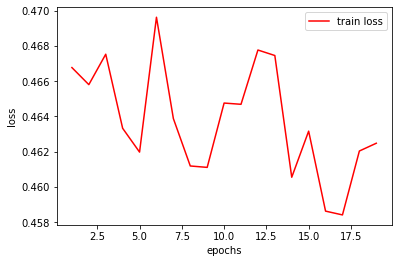

143/143 [==============================] - 4s 30ms/step - loss: 0.8471 - accuracy: 0.7198
test loss: 0.847121000289917, test acc: 0.7197633385658264


In [26]:
#model parameter
vocab_size = tokenizer.num_words
maxlen = x_train.shape[1]
embed_dim = 64

def build_lstm(vocab_size, embed_dim):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape = (maxlen, ), dtype = "int32"))

    #model.add(tf.keras.layers.Embedding(vocab_size, embed_dim, weights= [embedding_matrix]))
    model.add(tf.keras.layers.Embedding(vocab_size, embed_dim))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3, activation = "relu", return_sequences = True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3, activation = "tanh")))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(7, activation = "softmax"))

    return model

# training

batch_size = 512
epochs = 32

es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 16, verbose = 0)
mc = tf.keras.callbacks.ModelCheckpoint("transformer_weights.h5",monitor = "val_loss", mode = "min", patience = 16, save_best_only=True, save_weights_only = True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 8, mode= "min", verbose = 0)

callbacks_params = [es, mc, lr]

# gpu device 수동 할당
tf.debugging.set_log_device_placement(True)

with tf.device('/device:GPU:0'):

    model = build_lstm(vocab_size, embed_dim)

    optimizer = tf.keras.optimizers.Adam(lr = 5e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

    model.compile(
        #optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
        optimizer = optimizer,
        loss = loss,
        metrics = metric
    )

    model.summary()

    # cross validation
    n_folds = 3
    
    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

    for i, (tra_cv, val_cv) in enumerate(cv.split(x_train, y_train)):
        print("training model for cv:{}".format(i+1))
        hist = model.fit(x_train[tra_cv,:], y_train[tra_cv], validation_data = (x_train[val_cv,:], y_train[val_cv]), 
                        epochs = epochs, batch_size = batch_size, verbose = 1,
                        callbacks = callbacks_params)
    
    loss, acc = hist.history["loss"], hist.history["accuracy"]
    epoch_axis = range(1, len(loss) + 1)
    plt.plot(epoch_axis, loss, "r", label = "train loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show() 

eval_loss, eval_acc = model.evaluate(x_test, y_test)
print("test loss: {}, test acc: {}".format(eval_loss, eval_acc))

(30000, 64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "attention_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 64)       1920000     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 17, 256)      197632      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 17, 256), (N 394240      bidirectional_2[0][0]            
_____________________________________________________________________________________

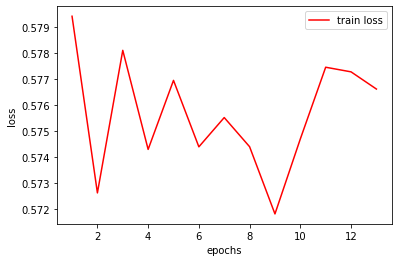

143/143 [==============================] - 4s 25ms/step - loss: 0.9376 - accuracy: 0.6950
test loss: 0.9376471042633057, test acc: 0.695004403591156


In [27]:
# 양방향 LSTM + attention mechanism

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis = 1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# word2vec weight 적용(중복시 생략 가능)
import gensim
word2vec_model = gensim.models.Word2Vec.load("ko.bin")
embedding_matrix = np.zeros((vocab_size, embed_dim), dtype = np.float32)

for word, idx in tokenizer.word_index.items():
    embedding_vector = word2vec_model[word] if word in word2vec_model else None

    if idx <= vocab_size:
        break
        
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

print(embedding_matrix.shape)

def attention_lstm(vocab_size, embed_dim, maxlen):
    inputs = tf.keras.layers.Input(shape = (maxlen,), dtype = "int32")
    x = tf.keras.layers.Embedding(vocab_size, embed_dim, input_length = maxlen, mask_zero = True)(inputs)

    x_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.3, recurrent_dropout = 0.3, activation = "relu", return_sequences = True))(x)
    x_lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.3, recurrent_dropout = 0.3, activation = "relu", return_sequences = True, return_state = True))(x_lstm)
    state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
    state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

    attention_ban = BahdanauAttention(256)
    context_vector, attention_weights = attention_ban(x_lstm, state_h)
    x = tf.keras.layers.Dense(128, activation = "relu")(context_vector)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(7, activation = "softmax")(x)

    model = tf.keras.models.Model(inputs, outputs, name = "attention_lstm")

    return model
    


# training
batch_size = 512
epochs = 32

# gpu device 수동 할당
tf.debugging.set_log_device_placement(True)

with tf.device('/device:GPU:0'):

    # callback parameter
    es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 12, verbose = 0)
    mc = tf.keras.callbacks.ModelCheckpoint("attention_lstm_weights.h5",monitor = "val_loss", mode = "min", patience = 12, save_best_only = True, save_weights_only = True)
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 8, mode= "min", verbose = 0)

    callbacks_params = [es, mc, lr]


    model = attention_lstm(vocab_size, embed_dim, maxlen)

    optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

    #optimizer = "adam"
    #metric = ['sparse_categorical_accuracy']

    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = metric
    )

    model.summary()

    # cross validation
    n_folds = 3

    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

    for i, (tra_cv, val_cv) in enumerate(cv.split(x_train, y_train)):
        print("training model for cv:{}".format(i+1))
        hist = model.fit(x_train[tra_cv,:], y_train[tra_cv], validation_data = (x_train[val_cv,:], y_train[val_cv]), 
                        epochs = epochs, batch_size = batch_size, verbose = 1,
                        callbacks = callbacks_params)

    loss, acc = hist.history["loss"], hist.history["accuracy"]
    epoch_axis = range(1, len(loss) + 1)
    plt.plot(epoch_axis, loss, "r", label = "train loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show() 

eval_loss, eval_acc = model.evaluate(x_test, y_test)
print("test loss: {}, test acc: {}".format(eval_loss, eval_acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 17, 64)            2219712   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               

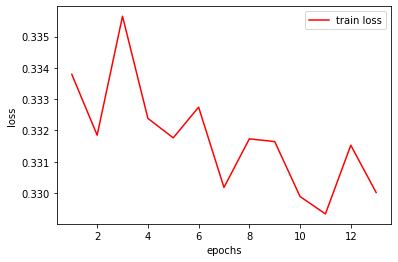

143/143 [==============================] - 1s 4ms/step - loss: 0.6903 - accuracy: 0.7800
test loss: 0.6903169751167297, test acc: 0.7800175547599792


In [29]:
# transformer를 이용한 모델

# Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = tf.keras.models.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation = "relu"), tf.keras.layers.Dense(embed_dim)]
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.training = True

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=self.training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=self.training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, x):
        maxlen = self.maxlen
        #positions = tf.range(start=0, limit = maxlen, delta=1)
        positions = tf.range(start=0, limit = maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    

class Encoder(tf.keras.models.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(Encoder, self).__init__()
        self.frontLayer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.backLayer = TransformerBlock(embed_dim, num_heads, ff_dim, rate)
        
    def call(self, inputs):
        x = self.frontLayer(inputs)
        x = self.backLayer(x)
        return x

def transformer_classification(embed_dim, num_heads, ff_dim, rate, maxlen, units):

    inputs = tf.keras.layers.Input(shape = (maxlen,), dtype = "int32")
    encoder = Encoder(maxlen, vocab_size, embed_dim, num_heads, ff_dim, rate = 0.3)

    x = encoder(inputs)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(units, activation="relu")(x)
    outputs = tf.keras.layers.Dense(7, activation="softmax")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name = "transformer")

    return encoder, model

# training
batch_size = 512
epochs = 32

es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 12, verbose = 0)
mc = tf.keras.callbacks.ModelCheckpoint("transformer_weights.h5",monitor = "val_loss", mode = "min", patience = 12, save_best_only=True, save_weights_only = True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 8, mode= "min", verbose = 0)

callbacks_params = [es, mc, lr]

# gpu device 수동 할당
tf.debugging.set_log_device_placement(True)

with tf.device('/device:GPU:0'):

    # model parameter
    vocab_size = tokenizer.num_words
    maxlen = x_train.shape[1]
    embed_dim = 64
    num_heads = 16
    ff_dim = 256
    rate = 0.3
    units = 128

    encoder, model = transformer_classification(embed_dim, num_heads, ff_dim, rate, maxlen, units)

    optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = metric
    )

    model.summary()

    # cross validation
    n_folds = 3

    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

    for i, (tra_cv, val_cv) in enumerate(cv.split(x_train, y_train)):
        print("training model for cv:{}".format(i+1))
        hist = model.fit(x_train[tra_cv,:], y_train[tra_cv], validation_data = (x_train[val_cv,:], y_train[val_cv]), 
                        epochs = epochs, batch_size = batch_size, verbose = 1,
                        callbacks = callbacks_params)

    loss, acc = hist.history["loss"], hist.history["accuracy"]
    epoch_axis = range(1, len(loss) + 1)
    plt.plot(epoch_axis, loss, "r", label = "train loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show() 

eval_loss, eval_acc = model.evaluate(x_test, y_test)
print("test loss: {}, test acc: {}".format(eval_loss, eval_acc))

In [ ]:
!pip install -q -U tensorflow-text
!pip install -q -U tf-models-official
!pip install -U tfds-nightly

import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')



In [58]:
# switch transformer

# Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ffn, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = ffn
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.training = True

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training= training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, x):
        maxlen = self.maxlen
        #positions = tf.range(start=0, limit = maxlen, delta=1)
        positions = tf.range(start=0, limit = maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    


# load balanced loss
def load_balanced_loss(router_probs, expert_mask):
    num_experts = tf.shape(expert_mask)[-1]
    density = tf.reduce_mean(expert_mask, axis = 0)
    density_proxy = tf.reduce_mean(router_probs, axis = 0)
    loss = tf.reduce_mean(density_proxy * density) * tf.cast((num_experts ** 2), tf.float32)

    return loss

class Router(tf.keras.layers.Layer):
    def __init__(self, num_experts, expert_capacity):
        super(Router, self).__init__()
        self.route = tf.keras.layers.Dense(num_experts)
        self.expert_capacity = expert_capacity
        self.num_experts = num_experts
    def call(self, inputs, training = False):
        router_logits = self.route(inputs)
        #router_logits = tf.reshape(router_logits,shape = [-1, router_logits.shape[1]])

        
        if training:
            router_logits += tf.random.uniform(shape = router_logits.shape, minval = 0.9, maxval = 1.1)
        

        router_probs = tf.keras.activations.softmax(router_logits, axis = 1)
        expert_gate, expert_index = tf.math.top_k(router_probs, k = 1)
        expert_mask = tf.one_hot(expert_index, depth = self.num_experts)
        aux_loss = load_balanced_loss(router_probs, expert_mask)

        self.add_loss(aux_loss)

        position_in_expert = tf.cast(tf.math.cumsum(expert_mask, axis = 0) * expert_mask, tf.dtypes.int32)
        expert_mask *= tf.cast(
            tf.math.less(
                tf.cast(position_in_expert, tf.dtypes.int32), self.expert_capacity
                ), tf.dtypes.float32)
        expert_mask_flat = tf.reduce_sum(expert_mask, axis = -1)
        expert_gate *= expert_mask_flat

        # Create binary dispatch_tensor [tokens_per_batch, num_experts, expert_capacity]
        # that is 1 if the token gets routed to the corresponding expert.

        combined_tensor = tf.expand_dims(
            expert_gate * expert_mask_flat * tf.squeeze(tf.one_hot(expert_index, depth=self.num_experts),1),-1,) * tf.squeeze(tf.one_hot(position_in_expert, depth=self.expert_capacity), 1)
      
        dispatch_tensor = tf.cast(combined_tensor, tf.dtypes.float32)

        return dispatch_tensor, combined_tensor

def create_feedforward_network(ff_dim, name=None):
    return tf.keras.models.Sequential([
                                       tf.keras.layers.Dense(ff_dim, activation="relu"), 
                                       tf.keras.layers.Dense(ff_dim)], name=name)

class Switch(tf.keras.layers.Layer):
    def __init__(self, num_experts, embed_dim, num_tokens_per_batch, capacity_factor=1):
        super(Switch, self).__init__()
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = [
            create_feedforward_network(embed_dim) for _ in range(num_experts)
        ]
        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(self.num_experts, self.expert_capacity)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        num_tokens_per_example = tf.shape(inputs)[1]
        num_tokens_per_batch = num_tokens_per_example * batch_size

        inputs = tf.reshape(inputs, [num_tokens_per_batch, self.embed_dim])

        dispatch_tensor, combine_tensor = self.router(inputs)
        expert_inputs = tf.einsum("ab,acd->cdb", inputs, dispatch_tensor)
        expert_inputs = tf.reshape(
            expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
        )
        expert_input_list = tf.unstack(expert_inputs, axis=0)
        expert_output_list = [
            self.experts[idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
        expert_outputs = tf.stack(expert_output_list, axis=1)
        expert_outputs_combined = tf.einsum(
            "abc,xba->xc", expert_outputs, combine_tensor
        )
        outputs = tf.reshape(
            expert_outputs_combined,
            [batch_size, num_tokens_per_example, self.embed_dim],
        )
        return outputs


def switch_transformer(num_experts, embed_dim, num_tokkens_per_batch, ff_dim, num_heads, maxlen, vocab_size, rate, units):

    switch = Switch(num_experts, embed_dim, num_tokens_per_batch)
    transformer_block = TransformerBlock(ff_dim, num_heads, switch, rate)

    inputs = tf.keras.layers.Input(shape=(maxlen,), batch_size = batch_size)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)

    x = embedding_layer(inputs)
    x = transformer_block(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.Dense(units, activation="relu")(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.Dense(units, activation="relu")(x)
    outputs = tf.keras.layers.Dense(7, activation="softmax")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name = "switch_transformer")
    return model


# training
batch_size = 512
epochs = 32

es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 12, verbose = 0)
mc = tf.keras.callbacks.ModelCheckpoint("switch_transformer_weights.h5",monitor = "val_loss", mode = "min", patience = 12, save_best_only=True, save_weights_only = True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 8, mode= "min", verbose = 0)

callbacks_params = [es, mc, lr]

# gpu device 수동 할당
tf.debugging.set_log_device_placement(True)

with tf.device('/device:GPU:0'):

    # model parameter
    vocab_size = tokenizer.num_words
    maxlen = x_train.shape[1]
    num_tokkens_per_batch = (batch_size * maxlen)
    num_experts = 16
    embed_dim = 64
    num_heads = 16
    ff_dim = 64
    rate = 0.3
    units = 128

    model = switch_transformer(num_experts, embed_dim, num_tokkens_per_batch, ff_dim, num_heads, maxlen, vocab_size, rate, units)

    optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = metric
    )

    model.summary()

    # cross validation
    n_folds = 3

    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

    

    for i, (tra_cv, val_cv) in enumerate(cv.split(x_train, y_train)):
        print("training model for cv:{}".format(i+1))
        hist = model.fit(x_train[tra_cv,:], y_train[tra_cv], validation_data = (x_train[val_cv,:], y_train[val_cv]), 
                        epochs = epochs, batch_size = batch_size, verbose = 1,
                        callbacks = callbacks_params)
    

    #hist = model.fit(x_train, y_train, verbose = 1, epochs = epochs, batch_size = batch_size)

    loss, acc = hist.history["loss"], hist.history["accuracy"]
    epoch_axis = range(1, len(loss) + 1)
    plt.plot(epoch_axis, loss, "r", label = "train loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show() 

eval_loss, eval_acc = model.evaluate(x_test, y_test)
print("test loss: {}, test acc: {}".format(eval_loss, eval_acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "switch_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(512, 17)]               0         
_________________________________________________________________
token_and_position_embedding (512, 17, 64)             1921088   
_________________________________________________________________
transformer_block_22 (Transf (512, 17, 64)             399696    
_________________________________________________________________
global_average_pooling1d_14  (512, 64)                 0         
_________________________________________________________________
dropout_71 (Dropout)         (512, 64)                 0         
_________________________________________________________________
dense_749 (Dense)            (512, 128)                8320      
_________________________________________________________________
dropout_72 (Dropout)         (512, 128)         

InvalidArgumentError: ignored

In [59]:
8704 / 17

512.0

In [ ]:
# torch를 이용한 kobert 모델
!pip install mxnet
!pip install gluonnlp 
!pip install sentencepiece
!pip install transformers==3 # 최신 버전으로 설치하면 "Input: must be Tensor, not str" 라는 에러 발생
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

output.clear()

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

##GPU 사용 시
device = torch.device("cuda:0")
bertmodel, vocab = get_pytorch_kobert_model()

# cuda 사용 불사기 gpu로..
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [
        torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

# 기본 Bert tokenizer 사용
tokenizer = get_tokenizer() # kobert 전용 토크나이저
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

class BERTDataset(Dataset):
    def __init__(self, dataset,bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        
        self.sentences = [transform(i) for i in dataset["title"]]
        self.labels = [i for i in dataset["topic_idx"]]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# Setting parameters
max_len = 32 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 512
warmup_ratio = 0.1
num_epochs = 8
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

# train test split
from sklearn.model_selection import train_test_split
trainSet, testSet = train_test_split(df_train, test_size = 0.2, random_state = 42)

# dataset 구축
data_train = BERTDataset(trainSet, tok, max_len, True, False)
data_test = BERTDataset(testSet, tok, max_len, True, False)

# pytorch용 DataLoader 사용
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size = 768, num_classes = 7, dr_rate = None,params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)

        return self.classifier(out)
      
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


# 학습 평가 지표인 accuracy 계산 -> 얼마나 타겟값을 많이 맞추었는가
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
  
# 모델 학습 시작
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

using cached model
using cached model
using cached model


In [ ]:
# kobert model using tensorflow
!git clone https://github.com/google-research/bert

import os
import sys
import json
import nltk
import random
import logging
import tensorflow as tf
import sentencepiece as spm

from glob import glob
from google.colab import auth, drive
from tensorflow.keras.utils import Progbar

sys.path.append("bert")

from bert import modeling, optimization, tokenization
from bert.run_pretraining import input_fn_builder, model_fn_builder

auth.authenticate_user()

# configure logging
log = logging.getLogger('tensorflow')
log.setLevel(logging.INFO)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s :  %(message)s')
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
sh.setFormatter(formatter)
log.handlers = [sh]

if 'COLAB_TPU_ADDR' in os.environ:
  log.info("Using TPU runtime")
  USE_TPU = True
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']

  with tf.Session(TPU_ADDRESS) as session:
    log.info('TPU address is ' + TPU_ADDRESS)
    # Upload credentials to TPU.
    with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
    tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
    
else:
    log.warning('Not connected to TPU runtime')
    USE_TPU = False

MAX_SEQ_LENGTH = 128 
MASKED_LM_PROB = 0.15 
MAX_PREDICTIONS = 20 
DO_LOWER_CASE = True 
PROCESSES = 4 
PRETRAINING_DIR = "pretraining_data" 



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7, n_jobs = -1)

flatten = tf.keras.layers.Flatten()

x_train_knn, y_train_knn = flatten(encoder(x_train)), y_train
x_test_knn, y_test_knn = flatten(encoder(x_test)), y_test

knn.fit(x_train_knn, y_train_knn)
eval = knn.score(x_test_knn, y_test_knn)

print(eval)

0.7082466323513307


In [ ]:
#svc model
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train_knn, y_train_knn)
eval = svc.score(x_test_knn, y_test_knn)
print(eval)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
flatten = tf.keras.layers.Flatten()

x_train_knn, y_train_knn = flatten(encoder(x_train)), y_train
x_test_knn, y_test_knn = flatten(encoder(x_test)), y_test


# knn algorithm using keras and gpu

def knn_algorithm(feature_num, n_neighbors = 7):

    x_data_train = tf.compat.v1.placeholder(shape = [None, feature_num], dtype = tf.float32)
    y_data_train = tf.compat.v1.placehodler(shape = [None, 7], dtype = tf.float32)
    x_data_test = tf.compat.v1.placeholder(shape = [None, feature_num], dtype = tf.float32)

    distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train, tf.expand_dims(x_data_test, 1))), axis = 2)
    _, top_k_indices = tf.nn.top_k(tf.negative(distance), k = n_neighbors)
    sum_up_predictions = tf.reduce_sum(top_k_label, axis = 1)
    prediction = tf.argmax(sum_up_predictions, axis = 1)
    
    return prediction

knn_predict = knn_algorithm(21 * 32, n_neighbors = 7)

datasets_dict = {
    x_data_train : x_train_knn,
    x_data_test : x_test_knn,
    y_data_train : y_train_knn
}

# knn training from tensorflow
sess = tf.Session()
y_test_pred = sess.run(knn_predict, feed_dict = datasets_dict)

# evaluation

knn_acc = 0

for pred, actual in zip(y_test_pred, y_test_knn):
    if pred == actual:
        knn_acc += 1

knn_eval_acc = knn_acc / len(knn_acc)
print("knn accuracy for testing: ", knn_eval_acc)

In [30]:
from google.colab import files

# test file -> convert word embedding vector

submission_test = preprocessing(df_test, True)
submission_test = tokenizer.texts_to_sequences(submission_test)
submission_test = pad_sequences(submission_test, padding = "post", dtype = "int32", maxlen = maxlen)

def softmax_toIdx(predictions):
    topic_Idx = np.argmax(predictions, axis = 1).reshape(-1,1)
    return topic_Idx

# prediction
submission_topic = softmax_toIdx(model.predict(submission_test))

# submission 
submission = pd.read_csv(PATH + "sample_submission.csv")
submission["topic_idx"] = submission_topic
submission.to_csv("submission.csv", index = False)
files.download("submission.csv")

time for preprocessing: 134.63449931144714s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# test file -> convert word embedding vector

submission_test = preprocessing(df_test)
submission_test = tokenizer.texts_to_sequences(submission_test)
submission_test = pad_sequences(submission_test, padding = "post", dtype = "int32", maxlen = maxlen)

def softmax_toIdx(predictions):
    topic_Idx = np.argmax(predictions, axis = 1).reshape(-1,1)
    return topic_Idx

# prediction
submission_topic = softmax_toIdx(model_att.predict(submission_test))

# submission 
submission = pd.read_csv(PATH + "sample_submission.csv")
submission["topic_idx"] = submission_topic
submission.to_csv("submission_att.csv", index = False)
files.download("submission_att.csv")